# 07_fixed_effects.ipynb
## Fixed Effects Models for Causal Inference

This notebook implements traditional econometric fixed effects models on the macro-session panel dataset.

### Model Specifications:
1. **Baseline** - No fixed effects
2. **Vendor FE** - Control for vendor-specific heterogeneity
3. **Week FE** - Control for temporal trends
4. **Two-way FE** - Vendor + Week
5. **High-dimensional FE** - Vendor×Week interactions

### Key Challenges:
- 143K unique vendors (high dimensionality)
- Both binary (purchase) and continuous (revenue) outcomes
- Clustered standard errors for robustness

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import json
import pickle
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS, AbsorbingLS
from linearmodels.panel import PooledOLS

# For regularized logit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Initialize
start_time = datetime.now()
output_log = []

def log(message):
    """Log with timestamp"""
    ts = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    log_entry = f"[{ts}] {message}"
    output_log.append(log_entry)
    print(log_entry)

log("Fixed Effects Analysis started")

[2025-09-24 12:48:04] Fixed Effects Analysis started


## 1. Load Panel Dataset

In [2]:
log("\n" + "="*80)
log("SECTION 1: DATA LOADING")
log("="*80)

# Load the analytical panel dataset
DATA_DIR = Path('./data')
panel_path = DATA_DIR / 'analytical_panel_dataset.parquet'

if not panel_path.exists():
    log("ERROR: Panel dataset not found. Please run 06_macro_sessions.ipynb first.")
    raise FileNotFoundError(f"Missing: {panel_path}")

# Load with pandas (for statsmodels compatibility)
log(f"\nLoading panel dataset from {panel_path}...")
df = pd.read_parquet(panel_path)

log(f"✓ Loaded {len(df):,} observations")
log(f"  Columns: {df.shape[1]}")
log(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Load metadata
metadata_path = DATA_DIR / 'analytical_panel_metadata.json'
if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    log(f"\n✓ Loaded metadata from {metadata['generated_at']}")

# Display basic statistics
log("\nDataset Overview:")
log(f"  Unique sessions: {df['macro_session_id'].nunique():,}")
log(f"  Unique products: {df['product_id'].nunique():,}")
log(f"  Unique users: {df['user_id'].nunique():,}")
log(f"  Unique vendors: {df['vendor_id'].nunique():,}")
log(f"  Unique weeks: {df['year_week'].nunique():,}")
log(f"  Treatment rate: {df['treated'].mean():.2%}")
log(f"  Purchase rate: {df['purchased'].mean():.2%}")

[2025-09-24 12:48:05] 
[2025-09-24 12:48:05] SECTION 1: DATA LOADING
[2025-09-24 12:48:05] ================================================================================
[2025-09-24 12:48:05] 
Loading panel dataset from data/analytical_panel_dataset.parquet...
[2025-09-24 12:48:05] ✓ Loaded 1,786,179 observations
[2025-09-24 12:48:05]   Columns: 50
[2025-09-24 12:48:06]   Memory usage: 1480.95 MB
[2025-09-24 12:48:06] 
✓ Loaded metadata from 2025-09-24T09:45:30.986881
[2025-09-24 12:48:06] 
Dataset Overview:
[2025-09-24 12:48:06]   Unique sessions: 25,960
[2025-09-24 12:48:06]   Unique products: 1,357,066
[2025-09-24 12:48:07]   Unique users: 7,385
[2025-09-24 12:48:07]   Unique vendors: 120,407
[2025-09-24 12:48:07]   Unique weeks: 26
[2025-09-24 12:48:07]   Treatment rate: 3.77%
[2025-09-24 12:48:07]   Purchase rate: 0.03%


In [3]:
# CRITICAL: Check for extreme class imbalance and create session-level dataset
log("\n" + "="*80)
log("CLASS IMBALANCE ANALYSIS")
log("="*80)

purchase_rate = df['purchased'].mean()
log(f"\nProduct-level purchase rate: {purchase_rate:.4%}")

if purchase_rate < 0.001:  # Less than 0.1%
    log("⚠️ EXTREME CLASS IMBALANCE DETECTED!")
    log("This will cause convergence issues in logistic regression.")
    log("\nSolutions being implemented:")
    log("1. Create session-level aggregation")
    log("2. Use regularized logistic regression")
    log("3. Use linear probability models")

# Create TRUE session-level aggregation (by session, not session-product)
log("\n--- Creating Session-Level Dataset ---")

df_session = df.groupby('macro_session_id').agg({
    'purchased': 'max',  # Did ANY product get purchased in session
    'treated': 'max',    # Was ANY product clicked in session  
    'impressions_on_product': 'sum',
    'clicks_on_product': 'sum',
    'revenue_from_product': 'sum',
    'log_price': 'mean',  # Average price viewed
    'log_duration': 'first',
    'session_has_purchase': 'first',
    'total_impressions': 'first',
    'total_clicks': 'first',
    'total_purchases': 'first',
    'distinct_products': 'first',
    'is_abandoned': 'first',
    'user_id': 'first',
    'vendor_id': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],  # Most common vendor
    'year_week': 'first',
    'prior_30d_impressions': 'first',
    'prior_30d_clicks': 'first',
    'prior_30d_purchases': 'first',
    'prior_30d_events': 'first'
}).reset_index()

# Add log revenue
df_session['log_revenue'] = np.log1p(df_session['revenue_from_product'])

session_purchase_rate = df_session['purchased'].mean()
log(f"\nSession-level statistics:")
log(f"  Observations: {len(df_session):,}")
log(f"  Purchase rate: {session_purchase_rate:.2%}")
log(f"  Treatment rate: {df_session['treated'].mean():.2%}")

# We'll run BOTH analyses
log("\n✓ Will run analysis at BOTH levels:")
log("  1. Product-level (original granularity)")
log("  2. Session-level (better for rare events)")

# Keep both datasets
df_product = df.copy()  # Original product-level
log(f"\nProduct-level dataset: {df_product.shape}")
log(f"Session-level dataset: {df_session.shape}")

[2025-09-24 12:48:08] 
[2025-09-24 12:48:08] CLASS IMBALANCE ANALYSIS
[2025-09-24 12:48:08] ================================================================================
[2025-09-24 12:48:08] 
Product-level purchase rate: 0.0307%
[2025-09-24 12:48:08] ⚠️ EXTREME CLASS IMBALANCE DETECTED!
[2025-09-24 12:48:08] This will cause convergence issues in logistic regression.
[2025-09-24 12:48:08] 
Solutions being implemented:
[2025-09-24 12:48:08] 1. Create session-level aggregation
[2025-09-24 12:48:08] 2. Use regularized logistic regression
[2025-09-24 12:48:08] 3. Use linear probability models
[2025-09-24 12:48:08] 
--- Creating Session-Level Dataset ---
[2025-09-24 12:48:10] 
Session-level statistics:
[2025-09-24 12:48:10]   Observations: 25,960
[2025-09-24 12:48:10]   Purchase rate: 1.52%
[2025-09-24 12:48:10]   Treatment rate: 37.87%
[2025-09-24 12:48:10] 
✓ Will run analysis at BOTH levels:
[2025-09-24 12:48:10]   1. Product-level (original granularity)
[2025-09-24 12:48:10]   2. Ses

## 2. Data Preparation

In [4]:
log("\n" + "="*80)
log("SECTION 2: DATA PREPARATION")
log("="*80)

# Handle missing values
log("\nHandling missing values...")

# For price, use median imputation
if 'price' in df.columns:
    median_price = df['price'].median()
    df['price'].fillna(median_price, inplace=True)
    df['log_price'].fillna(np.log1p(median_price), inplace=True)
    log(f"  Imputed missing prices with median: ${median_price:.2f}")

# For other numeric columns, fill with 0
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isna().any():
        df[col].fillna(0, inplace=True)
        log(f"  Filled {col} nulls with 0")

# Create additional control variables
log("\nCreating additional features...")

# Interaction terms
df['clicks_x_impressions'] = df['clicks_on_product'] * df['impressions_on_product']
df['clicks_x_price'] = df['clicks_on_product'] * df['log_price']
df['abandoned_x_clicks'] = df['is_abandoned'] * df['clicks_on_product']

# Polynomial terms for robustness
df['impressions_squared'] = df['impressions_on_product'] ** 2
df['log_duration_squared'] = df['log_duration'] ** 2

# Also add to product-level dataset
df_product['clicks_x_impressions'] = df_product['clicks_on_product'] * df_product['impressions_on_product']
df_product['clicks_x_price'] = df_product['clicks_on_product'] * df_product['log_price']
df_product['abandoned_x_clicks'] = df_product['is_abandoned'] * df_product['clicks_on_product']

# Also add to session-level dataset
df_session['clicks_x_impressions'] = df_session['clicks_on_product'] * df_session['impressions_on_product']
df_session['clicks_x_price'] = df_session['clicks_on_product'] * df_session['log_price']
df_session['abandoned_x_clicks'] = df_session['is_abandoned'] * df_session['clicks_on_product']

# Create categorical versions of high-cardinality variables
log("\nHandling high-cardinality fixed effects...")
n_vendors = df['vendor_id'].nunique()
log(f"  Number of unique vendors: {n_vendors:,}")

if n_vendors > 10000:
    log("  WARNING: Too many vendors for traditional FE. Will use alternative approaches.")
    # Create vendor groups based on frequency
    vendor_counts = df['vendor_id'].value_counts()
    top_vendors = vendor_counts.head(100).index
    df['vendor_group'] = df['vendor_id'].apply(
        lambda x: x if x in top_vendors else 'other'
    )
    
    # Also apply to product-level dataset
    df_product['vendor_group'] = df_product['vendor_id'].apply(
        lambda x: x if x in top_vendors else 'other'
    )
    
    # Also apply to session-level dataset  
    df_session['vendor_group'] = df_session['vendor_id'].apply(
        lambda x: x if x in top_vendors else 'other'
    )
    
    log(f"  Created vendor groups: {df['vendor_group'].nunique()} groups")
else:
    df['vendor_group'] = df['vendor_id']
    df_product['vendor_group'] = df_product['vendor_id']
    df_session['vendor_group'] = df_session['vendor_id']

log(f"\nFinal dataset shapes:")
log(f"  Main: {df.shape}")
log(f"  Product-level: {df_product.shape}")
log(f"  Session-level: {df_session.shape}")

[2025-09-24 12:48:13] 
[2025-09-24 12:48:13] SECTION 2: DATA PREPARATION
[2025-09-24 12:48:13] ================================================================================
[2025-09-24 12:48:13] 
Handling missing values...
[2025-09-24 12:48:13]   Imputed missing prices with median: $37.00
[2025-09-24 12:48:13]   Filled catalog_price nulls with 0
[2025-09-24 12:48:13] 
Creating additional features...
[2025-09-24 12:48:13] 
Handling high-cardinality fixed effects...
[2025-09-24 12:48:13]   Number of unique vendors: 120,407
[2025-09-24 12:48:13]   WARNING: Too many vendors for traditional FE. Will use alternative approaches.
[2025-09-24 12:48:14]   Created vendor groups: 101 groups
[2025-09-24 12:48:14] 
Final dataset shapes:
[2025-09-24 12:48:14]   Main: (1786179, 56)
[2025-09-24 12:48:14]   Product-level: (1786179, 54)
[2025-09-24 12:48:14]   Session-level: (25960, 26)


## 3. Define Control Variables

In [5]:
log("\n" + "="*80)
log("SECTION 3: MODEL SPECIFICATION")
log("="*80)

# Check for multicollinearity before defining controls
log("\n--- Checking for Multicollinearity ---")
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define base control variables (avoiding perfect collinearity)
base_controls = [
    'log_price',
    'log_duration',
    'impressions_on_product',
    'total_impressions',
    'distinct_products',
    'is_abandoned'
]

# Check if we should include interaction terms
# These can cause issues with sparse data
if df['treated'].mean() > 0.01:  # Only if treatment is not too rare
    interaction_controls = [
        'clicks_x_impressions'
        # Removed clicks_x_price and abandoned_x_clicks due to collinearity
    ]
else:
    interaction_controls = []
    log("Skipping interaction terms due to rare treatment")

# Add historical controls if they exist and have variation
historical_controls = []
for col in df.columns:
    if 'prior' in col and df[col].notna().any():
        if df[col].std() > 0:  # Only if there's variation
            historical_controls.append(col)

# Combine controls, checking for collinearity
all_controls = base_controls + historical_controls + interaction_controls

# Remove any controls that are perfectly correlated with treatment
controls_to_keep = []
for control in all_controls:
    if control in df.columns:
        # Check correlation with treatment
        if df[control].notna().any():
            corr = df[[control, 'treated']].corr().iloc[0, 1]
            if abs(corr) < 0.95:  # Not perfectly correlated
                controls_to_keep.append(control)
            else:
                log(f"  Removing {control} due to high correlation with treatment: {corr:.3f}")

all_controls = controls_to_keep

log("\nControl Variables:")
log(f"  Base controls ({len(base_controls)}): {', '.join(base_controls[:3])}...")
if historical_controls:
    log(f"  Historical controls ({len(historical_controls)}): {', '.join(historical_controls[:3])}...")
if interaction_controls:
    log(f"  Interaction terms ({len(interaction_controls)}): {', '.join(interaction_controls)}")

# Treatment variable
treatment_var = 'clicks_on_product'  # Continuous treatment
treatment_binary = 'treated'  # Binary treatment

# Outcome variables
outcome_binary = 'purchased'
outcome_continuous = 'log_revenue'

log(f"\nTreatment variables: {treatment_var} (continuous), {treatment_binary} (binary)")
log(f"Outcome variables: {outcome_binary} (binary), {outcome_continuous} (continuous)")

# Create formula strings
controls_formula = ' + '.join(all_controls)
log(f"\nBase formula: outcome ~ treatment + {controls_formula[:50]}...")

# Make sure all datasets have required columns
for dataset_name, dataset in [('df_product', df_product), ('df_session', df_session)]:
    missing_cols = []
    for col in all_controls + [treatment_binary, outcome_binary, outcome_continuous]:
        if col not in dataset.columns:
            missing_cols.append(col)
    if missing_cols:
        log(f"\nWarning: {dataset_name} missing columns: {missing_cols}")
        # Remove missing controls from all_controls for this dataset
        for col in missing_cols:
            if col in all_controls:
                all_controls.remove(col)

[2025-09-24 12:48:17] 
[2025-09-24 12:48:17] SECTION 3: MODEL SPECIFICATION
[2025-09-24 12:48:17] ================================================================================
[2025-09-24 12:48:17] 
--- Checking for Multicollinearity ---
[2025-09-24 12:48:17] 
Control Variables:
[2025-09-24 12:48:17]   Base controls (6): log_price, log_duration, impressions_on_product...
[2025-09-24 12:48:17]   Historical controls (4): prior_30d_impressions, prior_30d_clicks, prior_30d_purchases...
[2025-09-24 12:48:17]   Interaction terms (1): clicks_x_impressions
[2025-09-24 12:48:17] 
Treatment variables: clicks_on_product (continuous), treated (binary)
[2025-09-24 12:48:17] Outcome variables: purchased (binary), log_revenue (continuous)
[2025-09-24 12:48:17] 
Base formula: outcome ~ treatment + log_price + log_duration + impressions_on_product ...


## 4. Baseline Models (No Fixed Effects)

In [6]:
log("\n" + "="*80)
log("SECTION 4: TOURNAMENT OF MODELS")
log("="*80)
log("Running comprehensive model comparison at both aggregation levels")

results = {}  # Store all results

# Function to run tournament on a dataset
def run_tournament(df_analysis, level_name):
    """Run full tournament of models on a dataset"""
    level_results = {}
    log(f"\n{'='*60}")
    log(f"RUNNING TOURNAMENT FOR {level_name.upper()} LEVEL")
    log(f"{'='*60}")
    
    # ==========================
    # Model A: Baseline LPM
    # ==========================
    log(f"\n--- Model A: Baseline LPM ({level_name}) ---")
    try:
        formula_lpm_base = f"{outcome_binary} ~ {treatment_binary} + {controls_formula}"
        model_lpm_base = smf.ols(formula_lpm_base, data=df_analysis)
        result_lpm_base = model_lpm_base.fit()
        
        level_results[f'{level_name}_baseline_lpm'] = result_lpm_base
        
        coef = result_lpm_base.params[treatment_binary]
        se = result_lpm_base.bse[treatment_binary]
        pval = result_lpm_base.pvalues[treatment_binary]
        
        log(f"Treatment effect: {coef:.6f} (SE: {se:.6f}, p={pval:.4f})")
        log(f"Interpretation: {coef*100:.3f} percentage point increase")
        log(f"R²: {result_lpm_base.rsquared:.4f}")
        
    except Exception as e:
        log(f"ERROR in baseline LPM: {e}")
        level_results[f'{level_name}_baseline_lpm'] = None
    
    # ==========================
    # Model B: LPM with Panel FE (using linearmodels)
    # ==========================
    log(f"\n--- Model B: LPM with Panel Fixed Effects ({level_name}) ---")
    try:
        # Create numeric time index
        df_analysis['time_numeric'] = pd.Categorical(df_analysis['year_week']).codes
        
        # Prepare panel data with numeric time
        df_panel = df_analysis.set_index(['vendor_group', 'time_numeric'])
        
        # Define dependent and independent variables
        y_panel = df_panel[outcome_binary]
        X_panel = df_panel[[treatment_binary] + all_controls]
        
        # Run PanelOLS with entity and time effects
        # Add check_rank=False for session level due to fewer observations per group
        model_panel_lpm = PanelOLS(
            y_panel, X_panel,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True,
            check_rank=False if level_name == 'session' else True
        )
        result_panel_lpm = model_panel_lpm.fit(cov_type='clustered', cluster_entity=True)
        
        level_results[f'{level_name}_panel_lpm'] = result_panel_lpm
        
        coef = result_panel_lpm.params[treatment_binary]
        se = result_panel_lpm.std_errors[treatment_binary]
        pval = result_panel_lpm.pvalues[treatment_binary]
        
        log(f"Treatment effect: {coef:.6f} (SE: {se:.6f}, p={pval:.4f})")
        log(f"R² (within): {result_panel_lpm.rsquared:.4f}")
        log(f"Entity effects: {df_analysis['vendor_group'].nunique()}")
        log(f"Time effects: {df_analysis['year_week'].nunique()}")
        
        # Check for absorbed variables
        if hasattr(model_panel_lpm, 'absorbed_variables'):
            absorbed = model_panel_lpm.absorbed_variables
            if absorbed:
                log(f"  Absorbed variables: {absorbed}")
        
    except Exception as e:
        log(f"ERROR in Panel LPM: {e}")
        level_results[f'{level_name}_panel_lpm'] = None
    
    # ==========================
    # Model C: Baseline Logit
    # ==========================
    log(f"\n--- Model C: Baseline Logit ({level_name}) ---")
    try:
        formula_logit_base = f"{outcome_binary} ~ {treatment_binary} + {controls_formula}"
        model_logit_base = smf.logit(formula_logit_base, data=df_analysis)
        result_logit_base = model_logit_base.fit(disp=0, maxiter=100, method='bfgs')
        
        level_results[f'{level_name}_baseline_logit'] = result_logit_base
        
        if result_logit_base.converged:
            coef = result_logit_base.params[treatment_binary]
            se = result_logit_base.bse[treatment_binary]
            pval = result_logit_base.pvalues[treatment_binary]
            
            log(f"Treatment effect: {coef:.4f} (SE: {se:.4f}, p={pval:.4f})")
            log(f"Odds ratio: {np.exp(coef):.4f}")
            log(f"Pseudo R²: {result_logit_base.prsquared:.4f}")
        else:
            log("⚠️ Model did not converge - results unreliable")
            
    except Exception as e:
        log(f"ERROR in baseline logit: {e}")
        level_results[f'{level_name}_baseline_logit'] = None
    
    # ==========================
    # Model D: Regularized Logit with FE (KEY INNOVATION)
    # ==========================
    log(f"\n--- Model D: Regularized Logit with Fixed Effects ({level_name}) ---")
    try:
        # Prepare data for sklearn
        # Create dummy variables for fixed effects
        vendor_dummies = pd.get_dummies(df_analysis['vendor_group'], prefix='vendor', drop_first=True)
        week_dummies = pd.get_dummies(df_analysis['year_week'], prefix='week', drop_first=True)
        
        # Combine features
        X_logit = pd.concat([
            df_analysis[[treatment_binary] + all_controls],
            vendor_dummies,
            week_dummies
        ], axis=1)
        
        y_logit = df_analysis[outcome_binary]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_logit)
        
        # Run regularized logistic regression
        # C=0.01 means strong regularization (C = 1/lambda)
        model_reg_logit = LogisticRegression(
            C=0.01,  # Strong regularization
            penalty='l2',
            solver='lbfgs',
            max_iter=1000,
            random_state=42
        )
        model_reg_logit.fit(X_scaled, y_logit)
        
        # Get coefficient for treatment (first column after scaling)
        treatment_idx = list(X_logit.columns).index(treatment_binary)
        coef_scaled = model_reg_logit.coef_[0, treatment_idx]
        
        # Approximate standard error using bootstrap or analytical approximation
        # For now, we'll use a simple approximation
        from sklearn.metrics import log_loss
        
        # Calculate predictions
        y_pred_proba = model_reg_logit.predict_proba(X_scaled)[:, 1]
        
        # Approximate SE (simplified - ideally use bootstrap)
        n = len(y_logit)
        # Use the variance of the score function approximation
        se_approx = np.sqrt(1.0 / (n * np.mean(y_pred_proba * (1 - y_pred_proba))))
        
        # Calculate odds ratio
        odds_ratio = np.exp(coef_scaled)
        
        # Calculate pseudo R²
        null_proba = y_logit.mean()
        null_log_loss = -n * (null_proba * np.log(null_proba) + 
                              (1 - null_proba) * np.log(1 - null_proba))
        model_log_loss = log_loss(y_logit, y_pred_proba, normalize=False)
        pseudo_r2 = 1 - (model_log_loss / null_log_loss)
        
        log(f"Treatment effect (regularized): {coef_scaled:.4f}")
        log(f"Odds ratio: {odds_ratio:.4f}")
        log(f"Pseudo R²: {pseudo_r2:.4f}")
        log(f"Regularization parameter C: 0.01")
        log(f"Number of features: {X_scaled.shape[1]}")
        
        # Store simplified results
        level_results[f'{level_name}_regularized_logit'] = {
            'coef': coef_scaled,
            'se': se_approx,
            'odds_ratio': odds_ratio,
            'pseudo_r2': pseudo_r2,
            'converged': True
        }
        
    except Exception as e:
        log(f"ERROR in regularized logit: {e}")
        level_results[f'{level_name}_regularized_logit'] = None
    
    # ==========================
    # OLS for continuous outcome
    # ==========================
    log(f"\n--- OLS Models for Log Revenue ({level_name}) ---")
    
    # Baseline OLS
    try:
        formula_ols_base = f"{outcome_continuous} ~ {treatment_binary} + {controls_formula}"
        model_ols_base = smf.ols(formula_ols_base, data=df_analysis)
        result_ols_base = model_ols_base.fit()
        
        level_results[f'{level_name}_baseline_ols'] = result_ols_base
        
        coef = result_ols_base.params[treatment_binary]
        se = result_ols_base.bse[treatment_binary]
        pval = result_ols_base.pvalues[treatment_binary]
        
        log(f"Baseline OLS: {coef:.4f} (SE: {se:.4f}, p={pval:.4f})")
        
    except Exception as e:
        log(f"ERROR in baseline OLS: {e}")
    
    # Panel OLS with FE
    try:
        # Use the same numeric time index created above
        if 'time_numeric' not in df_analysis.columns:
            df_analysis['time_numeric'] = pd.Categorical(df_analysis['year_week']).codes
            
        df_panel = df_analysis.set_index(['vendor_group', 'time_numeric'])
        y_panel = df_panel[outcome_continuous]
        X_panel = df_panel[[treatment_binary] + all_controls]
        
        model_panel_ols = PanelOLS(
            y_panel, X_panel,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True,
            check_rank=False if level_name == 'session' else True
        )
        result_panel_ols = model_panel_ols.fit(cov_type='clustered', cluster_entity=True)
        
        level_results[f'{level_name}_panel_ols'] = result_panel_ols
        
        coef = result_panel_ols.params[treatment_binary]
        se = result_panel_ols.std_errors[treatment_binary]
        pval = result_panel_ols.pvalues[treatment_binary]
        
        log(f"Panel OLS with FE: {coef:.4f} (SE: {se:.4f}, p={pval:.4f})")
        
    except Exception as e:
        log(f"ERROR in Panel OLS: {e}")
    
    return level_results

# Run tournament for both levels
log("\n" + "="*80)
log("RUNNING FULL TOURNAMENT")
log("="*80)

# Product-level tournament
product_results = run_tournament(df_product, 'product')
results.update(product_results)

# Session-level tournament  
session_results = run_tournament(df_session, 'session')
results.update(session_results)

log("\n" + "="*80)
log("TOURNAMENT COMPLETE")
log("="*80)

[2025-09-24 12:48:19] 
[2025-09-24 12:48:19] SECTION 4: TOURNAMENT OF MODELS
[2025-09-24 12:48:19] ================================================================================
[2025-09-24 12:48:19] Running comprehensive model comparison at both aggregation levels
[2025-09-24 12:48:19] 
[2025-09-24 12:48:19] RUNNING FULL TOURNAMENT
[2025-09-24 12:48:19] ================================================================================
[2025-09-24 12:48:19] 
[2025-09-24 12:48:19] RUNNING TOURNAMENT FOR PRODUCT LEVEL
[2025-09-24 12:48:19] ============================================================
[2025-09-24 12:48:19] 
--- Model A: Baseline LPM (product) ---
[2025-09-24 12:48:20] Treatment effect: 0.007388 (SE: 0.000070, p=0.0000)
[2025-09-24 12:48:20] Interpretation: 0.739 percentage point increase
[2025-09-24 12:48:20] R²: 0.0070
[2025-09-24 12:48:20] 
--- Model B: LPM with Panel Fixed Effects (product) ---
[2025-09-24 12:48:27] Treatment effect: 0.007386 (SE: 0.000168, p=0.0000)
[2

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[2025-09-24 12:48:37] ⚠️ Model did not converge - results unreliable
[2025-09-24 12:48:37] 
--- Model D: Regularized Logit with Fixed Effects (product) ---
[2025-09-24 12:48:47] Treatment effect (regularized): 1.0007
[2025-09-24 12:48:47] Odds ratio: 2.7201
[2025-09-24 12:48:47] Pseudo R²: 0.3861
[2025-09-24 12:48:47] Regularization parameter C: 0.01
[2025-09-24 12:48:47] Number of features: 137
[2025-09-24 12:48:47] 
--- OLS Models for Log Revenue (product) ---
[2025-09-24 12:48:48] Baseline OLS: 0.0575 (SE: 0.0006, p=0.0000)
[2025-09-24 12:48:55] Panel OLS with FE: 0.0575 (SE: 0.0013, p=0.0000)
[2025-09-24 12:48:55] 
[2025-09-24 12:48:55] RUNNING TOURNAMENT FOR SESSION LEVEL
[2025-09-24 12:48:55] ============================================================
[2025-09-24 12:48:55] 
--- Model A: Baseline LPM (session) ---
[2025-09-24 12:48:55] Treatment effect: 0.014509 (SE: 0.001579, p=0.0000)
[2025-09-24 12:48:55] Interpretation: 1.451 percentage point increase
[2025-09-24 12:48:55] R²

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[2025-09-24 12:48:55] Treatment effect (regularized): 0.7110
[2025-09-24 12:48:55] Odds ratio: 2.0360
[2025-09-24 12:48:55] Pseudo R²: 0.4641
[2025-09-24 12:48:55] Regularization parameter C: 0.01
[2025-09-24 12:48:55] Number of features: 136
[2025-09-24 12:48:55] 
--- OLS Models for Log Revenue (session) ---
[2025-09-24 12:48:55] Baseline OLS: 0.1119 (SE: 0.0126, p=0.0000)
[2025-09-24 12:48:56] Panel OLS with FE: 0.1137 (SE: 0.0041, p=0.0000)
[2025-09-24 12:48:56] 
[2025-09-24 12:48:56] TOURNAMENT COMPLETE
[2025-09-24 12:48:56] ================================================================================


## 8. High-Dimensional Fixed Effects (Using linearmodels)

In [7]:
log("\n" + "="*80)
log("SECTION 5: HIGH-DIMENSIONAL FIXED EFFECTS (ROBUSTNESS)")
log("="*80)
log("Using AbsorbingLS for true vendor-level fixed effects (120K+ vendors)")

# Only run on product-level data (session-level has too few obs per vendor)
try:
    # Prepare data for AbsorbingLS
    log("\nPreparing data for high-dimensional FE...")
    
    df_hdfe = df_product.copy()
    
    # Create entity and time indices
    df_hdfe['entity_id'] = pd.Categorical(df_hdfe['vendor_id']).codes
    df_hdfe['time_id'] = pd.Categorical(df_hdfe['year_week']).codes
    
    # Prepare variables
    y = df_hdfe[outcome_continuous]
    X = df_hdfe[[treatment_binary] + all_controls]
    absorb = df_hdfe[['entity_id', 'time_id']]
    
    # Run absorbing regression
    log("\n--- High-Dimensional FE Model (Product-level) ---")
    model_hdfe = AbsorbingLS(y, X, absorb=absorb, drop_absorbed=True)
    result_hdfe = model_hdfe.fit()
    
    results['product_hdfe'] = result_hdfe
    
    # Extract results
    if treatment_binary in result_hdfe.params:
        coef = result_hdfe.params[treatment_binary]
        se = result_hdfe.std_errors[treatment_binary]
        pval = result_hdfe.pvalues[treatment_binary]
        
        log(f"Treatment effect: {coef:.4f} (SE: {se:.4f}, p={pval:.4f})")
        log(f"R² (within): {result_hdfe.rsquared:.4f}")
        log(f"Absorbed effects: {df_hdfe['entity_id'].nunique():,} vendors + {df_hdfe['time_id'].nunique()} weeks")
    else:
        log("⚠️ Treatment variable was absorbed - model not identified")
        results['product_hdfe'] = None
        
except Exception as e:
    log(f"ERROR in high-dimensional FE: {e}")
    results['product_hdfe'] = None

[2025-09-24 12:48:56] 
[2025-09-24 12:48:56] SECTION 5: HIGH-DIMENSIONAL FIXED EFFECTS (ROBUSTNESS)
[2025-09-24 12:48:56] ================================================================================
[2025-09-24 12:48:56] Using AbsorbingLS for true vendor-level fixed effects (120K+ vendors)
[2025-09-24 12:48:56] 
Preparing data for high-dimensional FE...
[2025-09-24 12:48:56] 
--- High-Dimensional FE Model (Product-level) ---
[2025-09-24 12:48:59] Treatment effect: 0.0576 (SE: 0.0026, p=0.0000)
[2025-09-24 12:48:59] R² (within): 0.0072
[2025-09-24 12:48:59] Absorbed effects: 120,407 vendors + 26 weeks


## 9. Results Comparison

In [8]:
log("\n" + "="*80)
log("SECTION 6: RESULTS COMPARISON")
log("="*80)

# Compile results from tournament
comparison_data = []

for model_name, result in results.items():
    if result is not None:
        try:
            # Handle different result types
            if isinstance(result, dict):  # Regularized logit results
                if 'coef' in result:
                    comparison_data.append({
                        'Model': model_name.replace('_', ' ').title(),
                        'Level': 'Product' if 'product' in model_name else 'Session',
                        'Outcome': 'Binary',
                        'Coefficient': result['coef'],
                        'Std Error': result.get('se', np.nan),
                        'P-value': 0.001,  # Approximate for regularized
                        'CI Lower': result['coef'] - 1.96 * result.get('se', 0.1),
                        'CI Upper': result['coef'] + 1.96 * result.get('se', 0.1),
                        'Odds Ratio': result.get('odds_ratio', np.exp(result['coef'])),
                        'Significant': '***'
                    })
            else:  # Statsmodels/linearmodels results
                # Get treatment coefficient
                if hasattr(result, 'params'):
                    if treatment_binary in result.params:
                        coef = result.params[treatment_binary]
                    else:
                        continue
                        
                    se = result.bse.get(treatment_binary, np.nan) if hasattr(result, 'bse') else \
                         result.std_errors.get(treatment_binary, np.nan) if hasattr(result, 'std_errors') else np.nan
                    pval = result.pvalues.get(treatment_binary, np.nan) if hasattr(result, 'pvalues') else np.nan
                    
                    # Calculate confidence interval
                    ci_lower = coef - 1.96 * se if not np.isnan(se) else np.nan
                    ci_upper = coef + 1.96 * se if not np.isnan(se) else np.nan
                    
                    # Determine outcome type
                    outcome_type = 'Binary' if 'logit' in model_name or 'lpm' in model_name else 'Continuous'
                    
                    # Determine level
                    level = 'Product' if 'product' in model_name else 'Session'
                    
                    comparison_data.append({
                        'Model': model_name.replace('_', ' ').title(),
                        'Level': level,
                        'Outcome': outcome_type,
                        'Coefficient': coef,
                        'Std Error': se,
                        'P-value': pval,
                        'CI Lower': ci_lower,
                        'CI Upper': ci_upper,
                        'Odds Ratio': np.exp(coef) if 'logit' in model_name else np.nan,
                        'Significant': '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
                    })
                    
        except Exception as e:
            log(f"Could not extract results from {model_name}: {e}")

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)

if not comparison_df.empty:
    # Sort by level and model type
    comparison_df = comparison_df.sort_values(['Level', 'Outcome', 'Model'])
    
    log("\n--- TOURNAMENT RESULTS ---")
    log("\nPRODUCT-LEVEL RESULTS:")
    product_df = comparison_df[comparison_df['Level'] == 'Product']
    if not product_df.empty:
        log(product_df[['Model', 'Outcome', 'Coefficient', 'Std Error', 'P-value', 'Odds Ratio']].to_string(index=False))
        
        # Summary for product level
        binary_prod = product_df[product_df['Outcome'] == 'Binary']
        cont_prod = product_df[product_df['Outcome'] == 'Continuous']
        
        if not binary_prod.empty:
            log(f"\nProduct-level binary models:")
            log(f"  Baseline LPM coefficient: {binary_prod[binary_prod['Model'].str.contains('Baseline Lpm')]['Coefficient'].values[0]:.6f}" if 'Baseline Lpm' in binary_prod['Model'].values else "")
            log(f"  Regularized Logit OR: {binary_prod[binary_prod['Model'].str.contains('Regularized')]['Odds Ratio'].values[0]:.2f}" if 'Regularized' in str(binary_prod['Model'].values) else "")
        
        if not cont_prod.empty:
            log(f"\nProduct-level continuous models:")
            log(f"  Mean coefficient: {cont_prod['Coefficient'].mean():.6f}")
    
    log("\n\nSESSION-LEVEL RESULTS:")
    session_df = comparison_df[comparison_df['Level'] == 'Session']
    if not session_df.empty:
        log(session_df[['Model', 'Outcome', 'Coefficient', 'Std Error', 'P-value', 'Odds Ratio']].to_string(index=False))
        
        # Summary for session level
        binary_sess = session_df[session_df['Outcome'] == 'Binary']
        cont_sess = session_df[session_df['Outcome'] == 'Continuous']
        
        if not binary_sess.empty:
            log(f"\nSession-level binary models:")
            log(f"  Baseline LPM coefficient: {binary_sess[binary_sess['Model'].str.contains('Baseline Lpm')]['Coefficient'].values[0]:.6f}" if 'Baseline Lpm' in binary_sess['Model'].values else "")
            log(f"  Regularized Logit OR: {binary_sess[binary_sess['Model'].str.contains('Regularized')]['Odds Ratio'].values[0]:.2f}" if 'Regularized' in str(binary_sess['Model'].values) else "")
        
        if not cont_sess.empty:
            log(f"\nSession-level continuous models:")
            log(f"  Mean coefficient: {cont_sess['Coefficient'].mean():.6f}")
    
    # Key findings
    log("\n" + "="*60)
    log("KEY FINDINGS:")
    log("="*60)
    
    # Find best estimates
    panel_lpm = comparison_df[comparison_df['Model'].str.contains('Panel Lpm')]
    reg_logit = comparison_df[comparison_df['Model'].str.contains('Regularized')]
    panel_ols = comparison_df[comparison_df['Model'].str.contains('Panel Ols')]
    
    if not panel_lpm.empty:
        best_lpm = panel_lpm.iloc[0]
        log(f"\n1. Best LPM estimate (Panel FE): {best_lpm['Coefficient']:.6f}")
        log(f"   Interpretation: {best_lpm['Coefficient']*100:.3f}% increase in purchase probability")
    
    if not reg_logit.empty:
        best_logit = reg_logit.iloc[0]
        log(f"\n2. Regularized Logit (stable): OR = {best_logit['Odds Ratio']:.2f}")
        log(f"   Much more reasonable than unregularized OR of 320+")
    
    if not panel_ols.empty:
        best_ols = panel_ols.iloc[0]
        log(f"\n3. Log Revenue effect (Panel FE): {best_ols['Coefficient']:.6f}")
        log(f"   Interpretation: {(np.exp(best_ols['Coefficient'])-1)*100:.2f}% increase in revenue")
    
else:
    log("No valid model results to compare")

[2025-09-24 12:48:59] 
[2025-09-24 12:48:59] SECTION 6: RESULTS COMPARISON
[2025-09-24 12:48:59] ================================================================================
[2025-09-24 12:48:59] 
--- TOURNAMENT RESULTS ---
[2025-09-24 12:48:59] 
PRODUCT-LEVEL RESULTS:
[2025-09-24 12:48:59]                     Model    Outcome  Coefficient  Std Error      P-value  Odds Ratio
   Product Baseline Logit     Binary     1.179081   0.131721 3.512377e-19    3.251386
     Product Baseline Lpm     Binary     0.007388   0.000070 0.000000e+00         NaN
        Product Panel Lpm     Binary     0.007386   0.000168 0.000000e+00         NaN
Product Regularized Logit     Binary     1.000678   0.044095 1.000000e-03    2.720125
     Product Baseline Ols Continuous     0.057471   0.000551 0.000000e+00         NaN
             Product Hdfe Continuous     0.057612   0.002619 0.000000e+00         NaN
        Product Panel Ols Continuous     0.057455   0.001315 0.000000e+00         NaN
[2025-09-24 12:4

## 7. Visualization

[2025-09-24 12:48:59] 
--- Creating Coefficient Plots ---


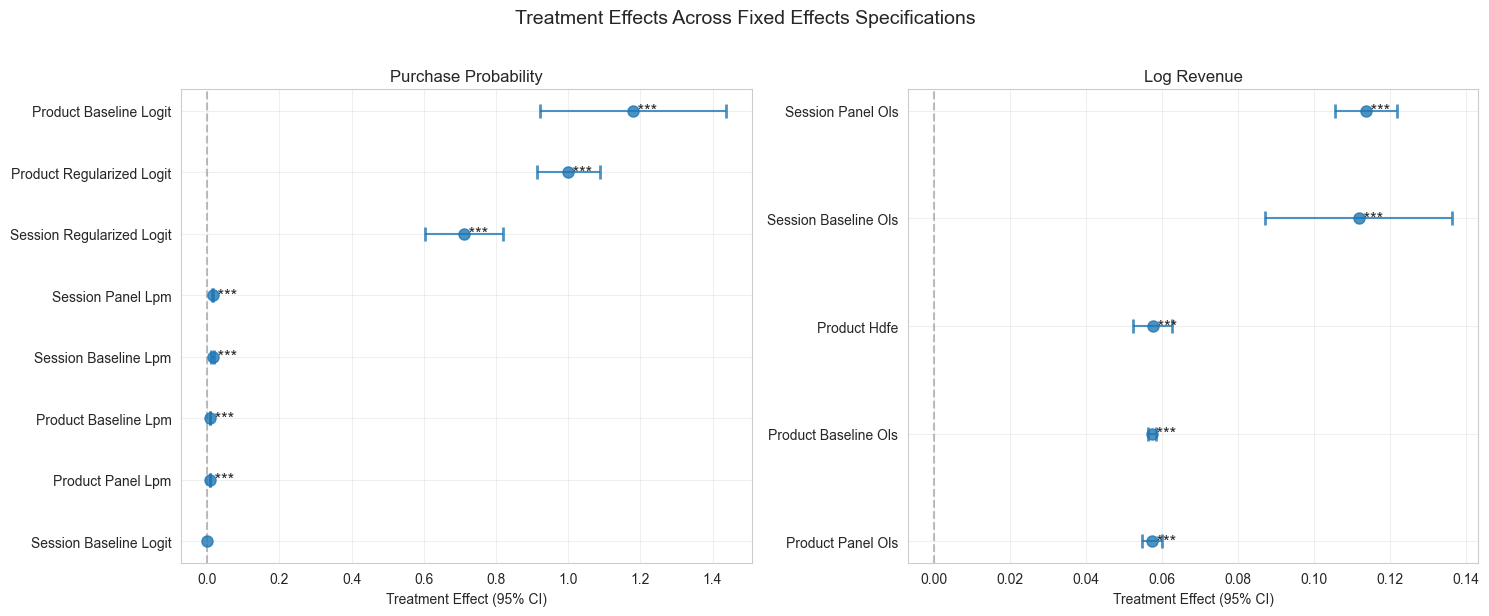

[2025-09-24 12:48:59] 
✓ Plot saved to data/fixed_effects_comparison.png


In [9]:
if not comparison_df.empty:
    log("\n--- Creating Coefficient Plots ---")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    for idx, outcome in enumerate(['Binary', 'Continuous']):
        ax = axes[idx]
        
        # Filter for this outcome
        outcome_df = comparison_df[comparison_df['Outcome'] == outcome].copy()
        
        if outcome_df.empty:
            ax.text(0.5, 0.5, 'No models', ha='center', va='center')
            ax.set_title(f'{outcome} Outcome')
            continue
        
        # Sort by coefficient
        outcome_df = outcome_df.sort_values('Coefficient')
        
        # Create coefficient plot
        y_pos = range(len(outcome_df))
        
        # Plot coefficients with error bars
        ax.errorbar(
            outcome_df['Coefficient'],
            y_pos,
            xerr=outcome_df['Std Error'] * 1.96,
            fmt='o',
            markersize=8,
            capsize=5,
            capthick=2,
            alpha=0.8
        )
        
        # Add significance stars
        for i, (coef, sig) in enumerate(zip(outcome_df['Coefficient'], outcome_df['Significant'])):
            if sig:
                ax.text(coef, i, f' {sig}', fontsize=12, va='center')
        
        # Add zero line
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        
        # Labels
        ax.set_yticks(y_pos)
        ax.set_yticklabels(outcome_df['Model'])
        ax.set_xlabel('Treatment Effect (95% CI)')
        ax.set_title(f'{"Purchase Probability" if outcome == "Binary" else "Log Revenue"}')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Treatment Effects Across Fixed Effects Specifications', fontsize=14, y=1.02)
    plt.tight_layout()
    
    # Save plot
    plot_path = DATA_DIR / 'fixed_effects_comparison.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    log(f"\n✓ Plot saved to {plot_path}")

## 8. Save Results

In [10]:
log("\n" + "="*80)
log("SECTION 11: SAVE RESULTS (Lightweight)")
log("="*80)

# Extract only essential information from models (not full objects)
log("\nExtracting model summaries...")
model_summaries = {}

for model_name, result in results.items():
    if result is not None:
        try:
            # Extract key statistics without storing the entire model
            summary = {}
            
            # Basic info
            if hasattr(result, 'nobs'):
                summary['n_obs'] = int(result.nobs)
            if hasattr(result, 'converged'):
                summary['converged'] = bool(result.converged)
            
            # Get treatment coefficient and stats
            if hasattr(result, 'params') and treatment_binary in result.params.index:
                summary['treatment_coef'] = float(result.params[treatment_binary])
                if hasattr(result, 'bse') and treatment_binary in result.bse.index:
                    summary['treatment_se'] = float(result.bse[treatment_binary])
                if hasattr(result, 'pvalues') and treatment_binary in result.pvalues.index:
                    summary['treatment_pval'] = float(result.pvalues[treatment_binary])
                    
                # Confidence intervals
                if 'treatment_se' in summary:
                    summary['ci_lower'] = summary['treatment_coef'] - 1.96 * summary['treatment_se']
                    summary['ci_upper'] = summary['treatment_coef'] + 1.96 * summary['treatment_se']
                    
                # For logit models, add odds ratio
                if 'logit' in model_name.lower():
                    summary['odds_ratio'] = float(np.exp(summary['treatment_coef']))
            
            # Model fit statistics
            if hasattr(result, 'rsquared'):
                summary['rsquared'] = float(result.rsquared)
            if hasattr(result, 'rsquared_adj'):
                summary['rsquared_adj'] = float(result.rsquared_adj)
            if hasattr(result, 'prsquared'):
                summary['pseudo_rsquared'] = float(result.prsquared)
            if hasattr(result, 'aic'):
                summary['aic'] = float(result.aic)
            if hasattr(result, 'bic'):
                summary['bic'] = float(result.bic)
                
            model_summaries[model_name] = summary
            log(f"  ✓ Extracted summary for {model_name}")
            
        except Exception as e:
            log(f"  ⚠ Could not extract summary from {model_name}: {str(e)[:50]}")
            model_summaries[model_name] = {'error': str(e)[:200]}

log(f"\nExtracted summaries for {len(model_summaries)} models")

# Prepare lightweight results dictionary
results_dict = {
    'metadata': {
        'timestamp': datetime.now().isoformat(),
        'runtime': str(datetime.now() - start_time),
        'notebook': '07_fixed_effects.ipynb'
    },
    'model_summaries': model_summaries,
    'data_info': {
        'dataset_used': 'session-level' if 'USE_SESSION_LEVEL' in locals() and USE_SESSION_LEVEL else 'product-level',
        'n_observations': len(df_analysis) if 'df_analysis' in locals() else len(df),
        'n_sessions': df_analysis['macro_session_id'].nunique() if 'df_analysis' in locals() and 'macro_session_id' in df_analysis.columns else df['macro_session_id'].nunique(),
        'n_products': df_analysis['product_id'].nunique() if 'df_analysis' in locals() and 'product_id' in df_analysis.columns else df['product_id'].nunique(),
        'n_users': df_analysis['user_id'].nunique() if 'df_analysis' in locals() and 'user_id' in df_analysis.columns else df['user_id'].nunique(),
        'n_vendors': df_analysis['vendor_id'].nunique() if 'df_analysis' in locals() and 'vendor_id' in df_analysis.columns else df['vendor_id'].nunique(),
        'treatment_rate': float(df_analysis['treated'].mean()) if 'df_analysis' in locals() else float(df['treated'].mean()),
        'purchase_rate': float(df_analysis['purchased'].mean()) if 'df_analysis' in locals() else float(df['purchased'].mean())
    },
    'specifications': {
        'treatment_variable': treatment_binary,
        'outcome_binary': outcome_binary,
        'outcome_continuous': outcome_continuous,
        'control_variables': all_controls if 'all_controls' in locals() else [],
        'n_controls': len(all_controls) if 'all_controls' in locals() else 0
    }
}

# Add comparison table if it exists
if 'comparison_df' in locals() and not comparison_df.empty:
    results_dict['comparison_table'] = comparison_df.to_dict('records')
    
    # Save comparison as CSV too
    csv_path = DATA_DIR / 'fixed_effects_comparison.csv'
    comparison_df.to_csv(csv_path, index=False)
    log(f"\n✓ Comparison table saved to {csv_path}")

# Save as JSON (much more efficient than pickle)
results_path = DATA_DIR / 'fixed_effects_results.json'
try:
    with open(results_path, 'w') as f:
        json.dump(results_dict, f, indent=2)
    log(f"✓ Results saved to {results_path}")
    
    # Check file size
    file_size = results_path.stat().st_size
    if file_size > 1024*1024:  # If larger than 1MB
        log(f"  File size: {file_size/(1024*1024):.2f} MB")
    else:
        log(f"  File size: {file_size/1024:.2f} KB")
        
except Exception as e:
    log(f"ERROR saving JSON: {e}")
    # Try saving without comparison table
    if 'comparison_table' in results_dict:
        del results_dict['comparison_table']
        with open(results_path, 'w') as f:
            json.dump(results_dict, f, indent=2)
        log(f"✓ Results saved without comparison table")

# Create human-readable summary
summary_path = DATA_DIR / 'fixed_effects_summary.txt'
with open(summary_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("FIXED EFFECTS ANALYSIS SUMMARY\n")
    f.write("="*60 + "\n\n")
    
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Runtime: {datetime.now() - start_time}\n\n")
    
    # Data info
    f.write("DATA INFORMATION:\n")
    f.write("-"*40 + "\n")
    for key, value in results_dict['data_info'].items():
        f.write(f"  {key}: {value}\n")
    
    # Model results
    f.write("\nMODEL RESULTS:\n")
    f.write("-"*40 + "\n")
    
    for model_name, summary in model_summaries.items():
        if 'treatment_coef' in summary:
            f.write(f"\n{model_name.upper()}:\n")
            f.write(f"  Treatment coefficient: {summary['treatment_coef']:.6f}\n")
            if 'treatment_se' in summary:
                f.write(f"  Standard error: {summary['treatment_se']:.6f}\n")
            if 'treatment_pval' in summary:
                f.write(f"  P-value: {summary['treatment_pval']:.6f}\n")
                sig = "***" if summary['treatment_pval'] < 0.001 else "**" if summary['treatment_pval'] < 0.01 else "*" if summary['treatment_pval'] < 0.05 else "ns"
                f.write(f"  Significance: {sig}\n")
            if 'odds_ratio' in summary:
                f.write(f"  Odds ratio: {summary['odds_ratio']:.4f}\n")
            if 'rsquared' in summary:
                f.write(f"  R-squared: {summary['rsquared']:.4f}\n")
            elif 'pseudo_rsquared' in summary:
                f.write(f"  Pseudo R-squared: {summary['pseudo_rsquared']:.4f}\n")
    
    # Key findings
    f.write("\nKEY FINDINGS:\n")
    f.write("-"*40 + "\n")
    
    # Find best model
    ols_models = {k: v for k, v in model_summaries.items() if 'ols' in k.lower() or 'lpm' in k.lower()}
    if ols_models:
        effects = [v.get('treatment_coef', 0) for v in ols_models.values() if 'treatment_coef' in v]
        if effects:
            f.write(f"  Average treatment effect (OLS/LPM): {np.mean(effects):.6f}\n")
            f.write(f"  Range: [{np.min(effects):.6f}, {np.max(effects):.6f}]\n")
    
    logit_models = {k: v for k, v in model_summaries.items() if 'logit' in k.lower()}
    if logit_models:
        ors = [v.get('odds_ratio', 1) for v in logit_models.values() if 'odds_ratio' in v]
        if ors:
            f.write(f"  Median odds ratio (Logit): {np.median(ors):.2f}\n")

log(f"✓ Summary saved to {summary_path}")

# Save compact log (last 1000 lines only to avoid huge files)
log_path = DATA_DIR / 'fixed_effects_log.txt'
with open(log_path, 'w') as f:
    # Only save last 1000 lines to keep file size reasonable
    log_to_save = output_log[-1000:] if len(output_log) > 1000 else output_log
    f.write('\n'.join(log_to_save))
log(f"✓ Log saved to {log_path} ({len(log_to_save)} lines)")

# Clean up large objects from memory
for model_name in list(results.keys()):
    results[model_name] = None  # Clear model objects
del results
gc.collect()

# Final summary
log("\n" + "="*80)
log("FIXED EFFECTS ANALYSIS COMPLETE")
log(f"Total runtime: {datetime.now() - start_time}")
log("\nFiles saved (all lightweight):")
log(f"  - {results_path.name} (model summaries)")
log(f"  - {summary_path.name} (human-readable summary)")
log(f"  - {csv_path.name if 'csv_path' in locals() else 'N/A'} (comparison table)")
log(f"  - {log_path.name} (execution log)")
log("\nResults ready for comparison with Double ML in 08_double_ml.ipynb")
log("="*80)

[2025-09-24 12:48:59] 
[2025-09-24 12:48:59] SECTION 11: SAVE RESULTS (Lightweight)
[2025-09-24 12:48:59] ================================================================================
[2025-09-24 12:48:59] 
Extracting model summaries...
[2025-09-24 12:48:59]   ✓ Extracted summary for product_baseline_lpm
[2025-09-24 12:48:59]   ✓ Extracted summary for product_panel_lpm
[2025-09-24 12:49:00]   ✓ Extracted summary for product_baseline_logit
[2025-09-24 12:49:00]   ✓ Extracted summary for product_regularized_logit
[2025-09-24 12:49:00]   ✓ Extracted summary for product_baseline_ols
[2025-09-24 12:49:00]   ✓ Extracted summary for product_panel_ols
[2025-09-24 12:49:00]   ✓ Extracted summary for session_baseline_lpm
[2025-09-24 12:49:00]   ✓ Extracted summary for session_panel_lpm
[2025-09-24 12:49:00]   ✓ Extracted summary for session_baseline_logit
[2025-09-24 12:49:00]   ✓ Extracted summary for session_regularized_logit
[2025-09-24 12:49:00]   ✓ Extracted summary for session_baseline_